In [16]:
import argparse
import treegp
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from sklearn.gaussian_process.kernels import Kernel
import os
import treecorr

# plotting things
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17


def comp_2pcf_treecorr(x, y, k, bin_type='TwoD'):
    """measure the anisotropic 2pcf of some data."""
    cat = treecorr.Catalog(x=x, y=y, k=k, w=None)
    kk = treecorr.KKCorrelation(min_sep=0, max_sep=0.15, nbins=17,
                                bin_type=bin_type, bin_slop=0)
    kk.process(cat)

    return kk.xi

def raw_moments(im, ordx=1, ordy=1):

    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    rmom = sum(sum(im*posX**ordx*posY**ordy))
    
    return rmom

def centroids(im):
    M10 = raw_moments(im, ordx=1, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M01 = raw_moments(im, ordx=0, ordy=1)
    xbar = M10/M00
    ybar = M01/M00
    return xbar, ybar
    
def cent_moments(im, ordx=1, ordy=1):
    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    xbar, ybar = centroids(im)
    
    cmom = sum(sum(im*(posX-xbar)**ordx*(posY-ybar)**ordy))
    
    return cmom

def get_theta(g1, g2):
    # this give theta in degrees
    phi = np.arctan2(g2,g1)*180/np.pi
    if g1*g2> 0:
        #first, quadrant
        if g1 > 0:
            phi = phi
        #third quadrant
        else: 
            phi = phi+360
    # second quadrant
    elif g1 < 0 and g2 > 0:
        phi = phi
    # fouth quadrant
    elif g1 > 0 and g2 < 0:
        phi = phi+360 
    theta = phi/2
    return theta

def get_orient(im):
    xbar, ybar = centroids(im)
    M20 = raw_moments(im, ordx=2, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M02 = raw_moments(im, ordx=0, ordy=2)
    M11 = raw_moments(im, ordx=1, ordy=1)
    
    mu20p = M20/M00 - xbar**2
    mu02p = M02/M00 - ybar**2
    mu11p = M11/M00 - xbar*ybar
    
    #angle in degrees
    theta = get_theta(mu20p-mu02p,2*mu11p)
    return theta

def get_circ_data(thx, thy, R, d_sigma, e1, e2):
    coords = np.array([thx, thy]).T
    coords_circ = []
    d_sigmaC = []
    e1C = []
    e2C = []
    for i in range(len(coords)):
        if coords[i][0]**2 + coords[i][1]**2 < 1:
            coords_circ.append(coords[i])
            d_sigmaC.append(d_sigma[i])
            e1C.append(e1[i])
            e2C.append(e2[i])
    thx = np.array(coords_circ)[:,0]
    thy = np.array(coords_circ)[:,1]
    #param_circ = np.array(param_circ)
    return thx, thy, d_sigmaC, e1C, e2C

def initSeeds():
    seeds = list(range(6,11))+[22,23,25,26,27]+list(range(30,40))
    seeds +=list(range(42,54))+list(range(55,61))+list(range(62,90))
    seeds += list(range(90,171))
    return seeds

In [8]:
def get_simData(seed, kind, circ, R=1):
    # get simulation data: thx, thy, dsigma, e1, e2, with option for circle cut, default R=1
    if kind == "psfws":
        d = pickle.load(open("..//runsims//sameheightPsfws//outh_psfws_"+str(seed)+".pkl", 'rb'))
    elif kind =="rand":
        d = pickle.load(open("..//runsims//sameheightRand//outh_rand_"+str(seed)+".pkl", 'rb'))
    elif kind=="randMatch":
        d = pickle.load(open("..//runsims//matchSpeedRand//outv_rand_"+str(seed)+".pkl", 'rb'))

    for key in d.keys():
        d[key] = np.array(d[key])
    (thx, thy, _, _, _, sigma, e1, e2, _, _, _) = tuple(d.values())
    d_sigma = sigma - np.mean(sigma)

    if circ:
        thx, thy, d_sigma, e1, e2 = get_circ_data(thx,thy,R, d_sigma, e1, e2)
    return thx, thy, d_sigma, e1, e2 
        
def get_angles(seeds, kind, circ=False, R=1):
    #get angles of 2pcf
    theta_dsigma, theta_e1, theta_e2 = {}, {}, {}
    for seed in seeds:
        thx, thy, d_sigma, e1, e2 = get_simData(seed, kind, circ, R)
        # compute 2pcf
        xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)
        xi_e1 = comp_2pcf_treecorr(thx, thy, e1)
        xi_e2 = comp_2pcf_treecorr(thx, thy, e2)

        # compute angles
        theta_dsigma[seed] = get_orient(xi_dsigma)
        theta_e1[seed] = get_orient(xi_e1)
        theta_e2[seed] = get_orient(xi_e2)
    return theta_dsigma, theta_e1, theta_e2

def plothist(ax,para,clr, lbl=""):
    y, bin_edges, _ = ax.hist(para, bins=25, histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr, label=lbl)
    return ax

def plotAngles():
    seeds = initSeeds()
    
    theta_dsigmaP, theta_e1P, theta_e2P = get_angles(seeds, "psfws")
    theta_dsigmaR, theta_e1R, theta_e2R = get_angles(seeds, "rand")
    theta_dsigmaRM, theta_e1RM, theta_e2RM = get_angles(seeds, "randMatch")

    theta_dsigmaPC, theta_e1PC, theta_e2PC = get_angles(seeds, "psfws", circ=True)
    theta_dsigmaRC, theta_e1RC, theta_e2RC = get_angles(seeds, "rand", circ=True)
    theta_dsigmaRMC, theta_e1RMC, theta_e2RMC = get_angles(seeds, "randMatch", circ=True)
    
    paraP = [theta_dsigmaP.values(), theta_e1P.values(), theta_e2P.values()]
    paraR = [theta_dsigmaR.values(), theta_e1R.values(), theta_e2R.values()]
    paraPC = [theta_dsigmaPC.values(), theta_e1PC.values(), theta_e2PC.values()]
    paraRC = [theta_dsigmaRC.values(), theta_e1RC.values(), theta_e2RC.values()]
    paraRM = [theta_dsigmaRM.values(), theta_e1RM.values(), theta_e2RM.values()]
    paraRMC = [theta_dsigmaRMC.values(), theta_e1RMC.values(), theta_e2RMC.values()]
    
    fig,ax = plt.subplots(3,3,figsize=(16,10), sharey=True, sharex=True)

    for i in range(3):
        ax[0,i] = plothist(ax[0,i], paraP[i],'blue', "square fit")
        ax[0,i] = plothist(ax[0,i], paraPC[i],'orange', "circle fit")
        ax[1,i] = plothist(ax[1,i], paraR[i], 'blue')
        ax[1,i] = plothist(ax[1,i], paraRC[i], 'orange')
        ax[2,i] = plothist(ax[2,i], paraRM[i], "blue")
        ax[2,i] = plothist(ax[2,i], paraRMC[i], "orange")

    ax[0,0].set_title("$\delta\sigma$, psf-weather-station")
    ax[1,0].set_title("$\delta\sigma$, random")
    ax[0,1].set_title("e1, psf-weather-station")
    ax[1,1].set_title("e1, random")
    ax[0,2].set_title("e2, psf-weather-station")
    ax[1,2].set_title("e2, random")
    ax[2,0].set_title("$\delta\sigma$, random, match speed")
    ax[2,1].set_title("e1, random, match speed")
    ax[2,2].set_title("e2, random, match speed")

    [a.set_xlabel("Correlation function angle", labelpad=10) for a in ax[2]]
    [ax[i,0].set_ylabel("Frequency") for i in range(3)]
    ax[0,0].set_xticks(np.linspace(0,180,5))

    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()


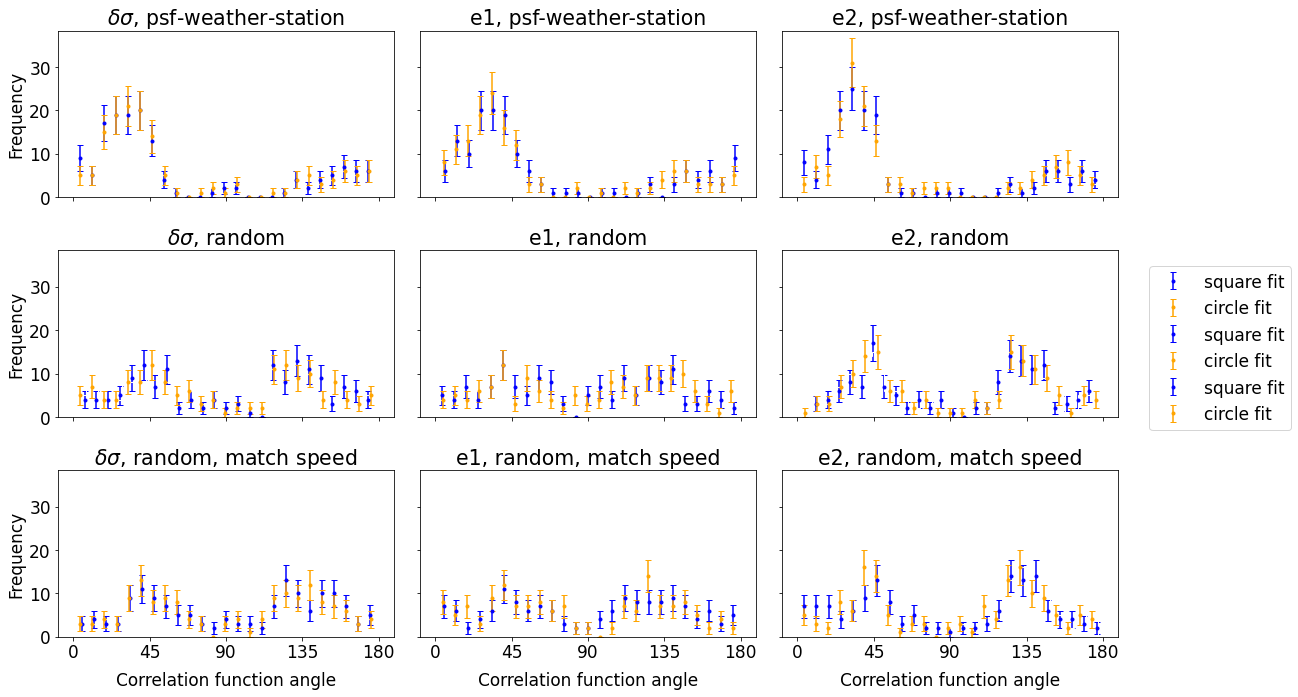

In [18]:
plotAngles()

# parameters plotting

In [10]:
def getPara(path, seeds):
    speeds ={}
    directions ={}
    for seed in seeds:
        d = pickle.load(open(path+str(seed)+".pkl", 'rb'))
        speeds[seed] = d['atmKwargs']['speed']
        directions[seed] = [x.deg for x in d['atmKwargs']['direction']]
    return speeds, directions

def firstMomSum(seeds, kind, circ=False, R=1):
    Sdsigma, Se1, Se2 = {}, {}, {}
    for seed in seeds:
        thx, thy, d_sigma, e1, e2 = get_simData(seed, kind, circ, R)
        # compute 2pcf
        xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)
        xi_e1 = comp_2pcf_treecorr(thx, thy, e1)
        xi_e2 = comp_2pcf_treecorr(thx, thy, e2)
        
        Sdsigma[seed] = raw_moments(xi_dsigma, ordx=2, ordy=0)
        Se1[seed] = raw_moments(xi_e1, ordx=2, ordy=0)
        Se2[seed] = raw_moments(xi_e2, ordx=2, ordy=0)
    return Sdsigma, Se1, Se2

def erbar(ax, x, y, clr, lbl):
    yerr = [y[i]**0.5 for i in range(len(y))]
    ax.errorbar(x, y, yerr,
                     marker = '.', drawstyle="steps-mid",
                     linestyle ="",capsize=3, color=clr, label=lbl)
    ax.plot(x,y)
    return ax

def pltVAR(ax, param, psfws=False, rand=False, randM = False):
    x = list(range(6))
    var = [np.var(pd.DataFrame(param).iloc[i]) for i in range(6)]
    if psfws: 
        ax = erbar(ax, x, var, "b", "psfws")
    elif rand: 
        ax= erbar(ax, x, var,"orange", "rand")
    elif randM: 
        ax = erbar(ax, x, var,"g", "rand match speed")
    return ax




In [13]:
seeds= initSeeds()
pathP = "..//runsims//sameheightPsfws//outh_psfws_"
pathR = "..//runsims//sameheightRand//outh_rand_"
pathRM = "..//runsims//matchSpeedRand//outv_rand_"

speedsP, directionsP = getPara(pathP, seeds) 
speedsR, directionsR = getPara(pathR, seeds) 
speedsRM, directionsRM = getPara(pathRM, seeds)

# get first moment sum
SdsigmaP, Se1P, Se2P = firstMomSum(seeds, "psfws")
SdsigmaR, Se1R, Se2R = firstMomSum(seeds, "rand")
SdsigmaRM, Se1RM, Se2RM = firstMomSum(seeds, "randMatch")

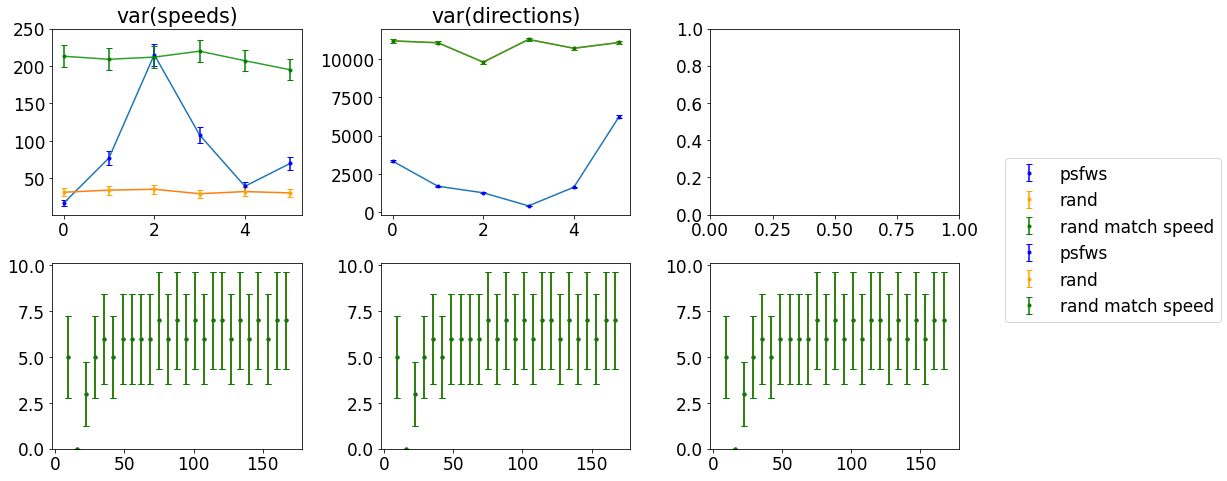

In [20]:
fig,ax = plt.subplots(2,3,figsize=(14,7))


ax[0,0] = pltVAR(ax[0,0], speedsP, psfws=True)
ax[0,0] = pltVAR(ax[0,0], speedsR,  rand=True)
ax[0,0] = pltVAR(ax[0,0], speedsRM,  randM=True)
ax[0,1] = pltVAR(ax[0,1], directionsP,  psfws=True)
ax[0,1] = pltVAR(ax[0,1], directionsR,  rand=True)
ax[0,1] = pltVAR(ax[0,1], directionsRM,  randM=True)
ax[0,0].set_ylim(ymax=250) 
ax[0,0].set_title("var(speeds)")
ax[0,1].set_ylim(ymax=12000) 
ax[0,1].set_title("var(directions)")

tings = [[SdsigmaP, SdsigmaR, SdsigmaRM], [Se1P, Se1R, Se1RM], [Se2P, Se2R, Se2RM]]
c = ["b", "orange", "g"]

for i in range(3):
    ax[1,0] = plothist(ax[1,0], tings[0][i],c[i])
    ax[1,1] = plothist(ax[1,1], tings[1][i],c[i])
    ax[1,2] = plothist(ax[1,2], tings[2][i],c[i])

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [27]:
import pandas as pd
pd.DataFrame([Se1P, Se1R, Se1RM], index=["P", "R", "RM"]).T

,P,R,RM
6,0.105958,0.429381,0.679433
7,1.385379,2.093557,1.125869
8,0.398787,15.007069,5.545231
9,2.712235,1.695341,1.877921
10,0.397983,1.716400,0.246815
...,...,...,...
166,0.536526,0.880224,0.378554
167,0.660818,0.828363,0.156896
168,0.660142,1.931161,0.330875
169,0.658508,0.846877,0.282384
